In [1]:
# Step 1: Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def load_asc_files(folder_path, columns):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.asc'):
            # Extract company name from filename (without extension) and avoid the last two characters
            company_name = os.path.splitext(filename)[0][:-2]  # Exclude the last two characters
            
            # Load the data
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, header=None, names=columns)
            
            # Add a new column for the company name
            df['Company'] = company_name
            
            # Append to the list
            data.append(df)
    
    # Concatenate all DataFrames into one
    return pd.concat(data, ignore_index=True)

In [3]:
# Step 2: Load Data
trade_folder = r"C:\Users\disch\Desktop\Intern_Season\Private\CiteSmart\assignment\2024_04_01_T"
quote_folder = r"C:\Users\disch\Desktop\Intern_Season\Private\CiteSmart\assignment\2024_04_01_Q"

trade_columns = ['Date', 'Time', 'Price', 'Volume', 'Aggressor Side', 'Trade Period', 
                 'Trade ID', 'Buyer', 'Buy Algo Type', 'Buy Order Capacity', 
                 'Seller', 'Sell Algo Type', 'Sell Order Capacity']
 
quote_columns = ['Date', 'Time', 'Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']

trade_data = load_asc_files(trade_folder, trade_columns)
quote_data = load_asc_files(quote_folder, quote_columns)

In [4]:
# Step 3: Preprocess Data
# Preprocessing; convert date time
def convert_to_minute(df):
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %H:%M:%S.%f')
    df['Minute'] = df['Datetime'].dt.floor('min')  # Truncate to minute
    return df

trade_data = convert_to_minute(trade_data)
quote_data = convert_to_minute(quote_data)

In [5]:
trade_data

,Date,Time,Price,Volume,Aggressor Side,Trade Period,Trade ID,Buyer,Buy Algo Type,Buy Order Capacity,Seller,Sell Algo Type,Sell Order Capacity,Company,Datetime,Minute
0,04/01/2024,09:07:26.230,3230.2,37,NaN,O,2024040100000378,1000000000128472,1,3,1000000000152524,1,3,ADANIENT_2024_04_01,2024-04-01 09:07:26.230,2024-04-01 09:07:00
1,04/01/2024,09:07:26.230,3230.2,5,NaN,O,2024040100000379,1000000000128472,1,3,1000000000099802,1,3,ADANIENT_2024_04_01,2024-04-01 09:07:26.230,2024-04-01 09:07:00
2,04/01/2024,09:07:26.230,3230.2,23,NaN,O,2024040100000380,1000000000128472,1,3,1000000000114687,1,3,ADANIENT_2024_04_01,2024-04-01 09:07:26.230,2024-04-01 09:07:00
3,04/01/2024,09:07:26.230,3230.2,2,NaN,O,2024040100000381,1000000000128472,1,3,1000000000129776,1,3,ADANIENT_2024_04_01,2024-04-01 09:07:26.230,2024-04-01 09:07:00
4,04/01/2024,09:07:26.230,3230.2,8,NaN,O,2024040100000382,1000000000128472,1,3,1000000000138062,0,1,ADANIENT_2024_04_01,2024-04-01 09:07:26.230,2024-04-01 09:07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933067,04/01/2024,15:52:15.932,3738.4,17,S,T,2024040167897223,1300000038242878,1,1,1300000038243641,1,2,TITAN_2024_04_01,2024-04-01 15:52:15.932,2024-04-01 15:52:00
2933068,04/01/2024,15:52:15.932,3738.4,10,S,T,2024040167897224,1300000038243310,1,3,1300000038243641,1,2,TITAN_2024_04_01,2024-04-01 15:52:15.932,2024-04-01 15:52:00
2933069,04/01/2024,15:52:15.932,3738.4,1,S,T,2024040167897225,1300000038243445,1,3,1300000038243641,1,2,TITAN_2024_04_01,2024-04-01 15:52:15.932,2024-04-01 15:52:00
2933070,04/01/2024,15:53:44.123,3738.4,9,S,T,2024040167897442,1300000038243753,1,3,1300000038244088,1,3,TITAN_2024_04_01,2024-04-01 15:53:44.123,2024-04-01 15:53:00


In [6]:
# Aggregate data at minute level
trade_agg = trade_data.groupby(['Minute', 'Company']).agg(
    num_trades=('Trade ID', 'count'),
    Open=('Price', 'first'),
    High=('Price', 'max'),
    Low=('Price', 'min'),
    Close=('Price', 'last'),
    total_volume=('Volume', 'sum'),
    total_buy_cap=('Buy Order Capacity', 'sum'),
    total_sell_cap=('Sell Order Capacity', 'sum'),
    trade_period=('Trade Period', lambda x: x.mode()[0]),  # Mode for trade period
    weighted_price=('Price', lambda x: np.average(x, weights=trade_data.loc[x.index, 'Volume'])),
    trade_imbalance_ratio=('Aggressor Side', lambda x: 
        (x == 'B').sum() / (x == 'S').sum() if (x == 'S').sum() > 0 else 0),
    trade_volume_imbalance_ratio=('Volume', lambda x: 
        trade_data.loc[x.index, 'Volume'][trade_data.loc[x.index, 'Aggressor Side'] == 'B'].sum() /
        trade_data.loc[x.index, 'Volume'][trade_data.loc[x.index, 'Aggressor Side'] == 'S'].sum() 
        if trade_data.loc[x.index, 'Volume'][trade_data.loc[x.index, 'Aggressor Side'] == 'S'].sum() > 0 else 0),
    order_cap_imbalnce_ratio=('Sell Order Capacity', lambda x: 
        (trade_data.loc[x.index, 'Sell Order Capacity'] != trade_data.loc[x.index, 'Sell Order Capacity']).sum() / len(x))
).reset_index()


# Adjust the aggregation for quote data
quote_agg = quote_data.groupby(['Minute', 'Company']).agg(
    avg_spread=('Bid Price', lambda x: np.mean(quote_data.loc[x.index, 'Ask Price'] - x)),
    max_spread=('Bid Price', lambda x: np.max(quote_data.loc[x.index, 'Ask Price'] - x)),
    min_spread=('Bid Price', lambda x: np.min(quote_data.loc[x.index, 'Ask Price'] - x)),
    total_bid_size=('Bid Size', 'sum'),
    total_ask_size=('Ask Size', 'sum'),
    weighted_avg_bid_price=('Bid Price', lambda x: np.average(x, weights=quote_data.loc[x.index, 'Bid Size'])),
    weighted_avg_ask_price=('Ask Price', lambda x: np.average(x, weights=quote_data.loc[x.index, 'Ask Size']))
).reset_index()

In [7]:
trade_agg

,Minute,Company,num_trades,Open,High,Low,Close,total_volume,total_buy_cap,total_sell_cap,trade_period,weighted_price,trade_imbalance_ratio,trade_volume_imbalance_ratio,order_cap_imbalnce_ratio
0,2024-04-01 09:07:00,ADANIENT_2024_04_01,386,3230.20,3230.20,3230.20,3230.20,6720,1113,1005,O,3230.20,0.0,0.0,0.0
1,2024-04-01 09:07:00,ADANIPORTS_2024_04_01,547,1356.80,1356.80,1356.80,1356.80,17367,1523,1436,O,1356.80,0.0,0.0,0.0
2,2024-04-01 09:07:00,APOLLOHOSP_2024_04_01,134,6401.00,6401.00,6401.00,6401.00,669,275,374,O,6401.00,0.0,0.0,0.0
3,2024-04-01 09:07:00,ASIANPAINT_2024_04_01,413,2860.95,2860.95,2860.95,2860.95,3740,1029,1125,O,2860.95,0.0,0.0,0.0
4,2024-04-01 09:07:00,AXISBANK_2024_04_01,257,1052.35,1052.35,1052.35,1052.35,19250,679,482,O,1052.35,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11889,2024-04-01 15:58:00,HEROMOTOCO_2024_04_01,1,4680.75,4680.75,4680.75,4680.75,1,3,3,T,4680.75,0.0,0.0,0.0
11890,2024-04-01 15:58:00,INFY_2024_04_01,1,1495.45,1495.45,1495.45,1495.45,15,3,3,T,1495.45,0.0,0.0,0.0
11891,2024-04-01 15:58:00,TITAN_2024_04_01,1,3738.40,3738.40,3738.40,3738.40,3,3,3,T,3738.40,0.0,0.0,0.0
11892,2024-04-01 15:59:00,ITC_2024_04_01,1,426.70,426.70,426.70,426.70,10,3,3,T,426.70,0.0,0.0,0.0


In [8]:
quote_agg

,Minute,Company,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price
0,2024-04-01 09:00:00,ADANIENT_2024_04_01,-88.240909,30.00,-336.90,202,710,3218.981188,NaN
1,2024-04-01 09:00:00,ADANIPORTS_2024_04_01,-107.592593,-0.05,-167.70,2094,3806,NaN,1337.366290
2,2024-04-01 09:00:00,APOLLOHOSP_2024_04_01,-338.050000,163.95,-762.75,643,507,6434.798834,NaN
3,2024-04-01 09:00:00,ASIANPAINT_2024_04_01,-215.527500,174.15,-427.00,1326,2400,3028.420852,NaN
4,2024-04-01 09:00:00,AXISBANK_2024_04_01,-64.345455,94.90,-162.10,228,8928,NaN,987.439992
...,...,...,...,...,...,...,...,...,...
11806,2024-04-01 15:54:00,HCLTECH_2024_04_01,2.000000,2.00,2.00,58,629,1558.000000,1560.000000
11807,2024-04-01 15:56:00,BPCL_2024_04_01,0.500000,0.50,0.50,1580,423,602.000000,602.500000
11808,2024-04-01 15:56:00,HEROMOTOCO_2024_04_01,9.000000,9.00,9.00,5,72,4690.000000,4699.000000
11809,2024-04-01 15:57:00,ITC_2024_04_01,0.100000,0.10,0.10,17860,1400,427.500000,427.600000


In [9]:
# Step 4: Merge and Feature Engineering
combined_data = pd.merge(trade_agg, quote_agg, on=['Minute', 'Company'], how='outer')

In [10]:
combined_data

,Minute,Company,num_trades,Open,High,Low,Close,total_volume,total_buy_cap,total_sell_cap,...,trade_imbalance_ratio,trade_volume_imbalance_ratio,order_cap_imbalnce_ratio,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price
0,2024-04-01 09:00:00,ADANIENT_2024_04_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-88.240909,30.00,-336.90,202.0,710.0,3218.981188,NaN
1,2024-04-01 09:00:00,ADANIPORTS_2024_04_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-107.592593,-0.05,-167.70,2094.0,3806.0,NaN,1337.366290
2,2024-04-01 09:00:00,APOLLOHOSP_2024_04_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-338.050000,163.95,-762.75,643.0,507.0,6434.798834,NaN
3,2024-04-01 09:00:00,ASIANPAINT_2024_04_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-215.527500,174.15,-427.00,1326.0,2400.0,3028.420852,NaN
4,2024-04-01 09:00:00,AXISBANK_2024_04_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-64.345455,94.90,-162.10,228.0,8928.0,NaN,987.439992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12032,2024-04-01 15:58:00,HEROMOTOCO_2024_04_01,1.0,4680.75,4680.75,4680.75,4680.75,1.0,3.0,3.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12033,2024-04-01 15:58:00,INFY_2024_04_01,1.0,1495.45,1495.45,1495.45,1495.45,15.0,3.0,3.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12034,2024-04-01 15:58:00,TITAN_2024_04_01,1.0,3738.40,3738.40,3738.40,3738.40,3.0,3.0,3.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12035,2024-04-01 15:59:00,ITC_2024_04_01,1.0,426.70,426.70,426.70,426.70,10.0,3.0,3.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
combined_data.dropna(inplace=True)

In [12]:
combined_data

,Minute,Company,num_trades,Open,High,Low,Close,total_volume,total_buy_cap,total_sell_cap,...,trade_imbalance_ratio,trade_volume_imbalance_ratio,order_cap_imbalnce_ratio,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price
134,2024-04-01 09:07:00,ADANIENT_2024_04_01,386.0,3230.20,3230.20,3230.20,3230.20,6720.0,1113.0,1005.0,...,0.000000,0.000000,0.0,-81.331402,1.00,-638.60,76268.0,128052.0,3258.433120,3214.149230
135,2024-04-01 09:07:00,ADANIPORTS_2024_04_01,547.0,1356.80,1356.80,1356.80,1356.80,17367.0,1523.0,1436.0,...,0.000000,0.000000,0.0,-28.452658,2.10,-262.30,328779.0,622512.0,1363.692199,1345.868445
136,2024-04-01 09:07:00,APOLLOHOSP_2024_04_01,134.0,6401.00,6401.00,6401.00,6401.00,669.0,275.0,374.0,...,0.000000,0.000000,0.0,-213.074272,4.80,-794.60,4315.0,6506.0,6593.837601,6311.395489
137,2024-04-01 09:07:00,ASIANPAINT_2024_04_01,413.0,2860.95,2860.95,2860.95,2860.95,3740.0,1029.0,1125.0,...,0.000000,0.000000,0.0,-133.111386,0.90,-427.00,95408.0,55572.0,2981.080010,2831.588966
138,2024-04-01 09:07:00,AXISBANK_2024_04_01,257.0,1052.35,1052.35,1052.35,1052.35,19250.0,679.0,482.0,...,0.000000,0.000000,0.0,-39.415396,0.25,-162.10,319318.0,669459.0,1052.886235,994.583352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11839,2024-04-01 15:42:00,INFY_2024_04_01,4.0,1495.45,1495.45,1495.45,1495.45,51.0,12.0,12.0,...,0.000000,0.000000,0.0,0.500000,0.50,0.50,386.0,67.0,1497.000000,1497.500000
11875,2024-04-01 15:45:00,ADANIPORTS_2024_04_01,4.0,1375.90,1375.90,1375.90,1375.90,63.0,8.0,12.0,...,0.000000,0.000000,0.0,1.500000,1.50,1.50,3895.0,1.0,1378.000000,1379.500000
11923,2024-04-01 15:48:00,BPCL_2024_04_01,5.0,600.70,600.70,600.70,600.70,45.0,15.0,15.0,...,0.666667,0.097561,0.0,0.500000,0.50,0.50,1680.0,423.0,602.000000,602.500000
11949,2024-04-01 15:50:00,CIPLA_2024_04_01,1.0,1498.65,1498.65,1498.65,1498.65,22.0,1.0,3.0,...,0.000000,0.000000,0.0,4.500000,4.50,4.50,1.0,993.0,1496.500000,1501.000000


In [13]:
combined_data['Next Close'] = combined_data.groupby('Company')['Close'].shift(-1)
combined_data['Return'] = (combined_data['Next Close'] - combined_data['Close']) / combined_data['Close']
combined_data.dropna(subset=['Next Close', 'Return'], inplace=True)

In [14]:
print(combined_data.columns)

Index(['Minute', 'Company', 'num_trades', 'Open', 'High', 'Low', 'Close',
       'total_volume', 'total_buy_cap', 'total_sell_cap', 'trade_period',
       'weighted_price', 'trade_imbalance_ratio',
       'trade_volume_imbalance_ratio', 'order_cap_imbalnce_ratio',
       'avg_spread', 'max_spread', 'min_spread', 'total_bid_size',
       'total_ask_size', 'weighted_avg_bid_price', 'weighted_avg_ask_price',
       'Next Close', 'Return'],
      dtype='object')


In [15]:
# Step 5: Train-Test Split
split_index = int(0.8 * len(combined_data))
train_data = combined_data[:split_index]
test_data = combined_data[split_index:]

In [16]:
# Step 6: Model Training

features = ['num_trades', 'Open', 'High', 'Low', 'Close', 'total_volume', 
            'total_buy_cap', 'total_sell_cap', 'trade_imbalance_ratio', 
            'trade_volume_imbalance_ratio', 'order_cap_imbalnce_ratio', 
            'avg_spread', 'max_spread', 'min_spread', 'total_bid_size', 
            'total_ask_size', 'weighted_avg_bid_price', 'weighted_avg_ask_price']

model = LinearRegression()

# Fit the model for each company
results = {}
for company in train_data['Company'].unique():
    company_train_data = train_data[train_data['Company'] == company]
    model.fit(company_train_data[features], company_train_data['Return'])
    # Store the model or results
    results[company] = model

# Predictions
test_data['Predicted Return'] = np.nan
for company in test_data['Company'].unique():
    company_test_data = test_data[test_data['Company'] == company]
    test_data.loc[test_data['Company'] == company, 'Predicted Return'] = model.predict(company_test_data[features])


C:\Users\disch\AppData\Local\Temp\ipykernel_14828\1707162422.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Return'] = np.nan


In [17]:
# Step 7: Model Evaluation

mse_dict = {}
for company in test_data['Company'].unique():
    company_test_data = test_data[test_data['Company'] == company]
    mse = mean_squared_error(company_test_data['Return'], company_test_data['Predicted Return'])
    mse_dict[company] = mse

# Print MSE values in a more readable format with an index
print("Mean Squared Error by Company:")
for index, (company, mse) in enumerate(mse_dict.items(), start=1):
    print(f"{index}. {company}: {mse:.4f}")  # Format to 4 decimal places for better readability


Mean Squared Error by Company:
1. BPCL_2024_04_01: 0.0003
2. BRITANNIA_2024_04_01: 0.0000
3. CIPLA_2024_04_01: 0.0001
4. COALINDIA_2024_04_01: 0.0003
5. DIVISLAB_2024_04_01: 0.0000
6. DRREDDY_2024_04_01: 0.0001
7. EICHERMOT_2024_04_01: 0.0000
8. GRASIM_2024_04_01: 0.0001
9. HCLTECH_2024_04_01: 0.0001
10. HDFCBANK_2024_04_01: 0.0002
11. HDFCLIFE_2024_04_01: 0.0003
12. HEROMOTOCO_2024_04_01: 0.0000
13. HINDALCO_2024_04_01: 0.0003
14. HINDUNILVR_2024_04_01: 0.0001
15. ICICIBANK_2024_04_01: 0.0002
16. INDUSINDBK_2024_04_01: 0.0001
17. INFY_2024_04_01: 0.0001
18. ITC_2024_04_01: 0.0003
19. JSWSTEEL_2024_04_01: 0.0002
20. KOTAKBANK_2024_04_01: 0.0001
21. TCS_2024_04_01: 0.0000
22. TITAN_2024_04_01: 0.0000
23. ADANIENT_2024_04_01: 0.0000
24. ADANIPORTS_2024_04_01: 0.0001
25. APOLLOHOSP_2024_04_01: 0.0002
26. ASIANPAINT_2024_04_01: 0.0000
27. AXISBANK_2024_04_01: 0.0002
28. BAJAJ-AUTO_2024_04_01: 0.0007
29. BAJAJFINSV_2024_04_01: 0.0001
30. BAJFINANCE_2024_04_01: 0.0003
31. BHARTIARTL_2024_04_

In [18]:
# Step 8: Correlation Analysis

# Create a pivot table to calculate the average correlation across companies per minute
pivoted_data = test_data.pivot_table(index='Minute', columns='Company', values='Return')
correlation_per_minute = pivoted_data.corr().mean(axis=1)

correlation_per_minute

Company
ADANIENT_2024_04_01      0.161589
ADANIPORTS_2024_04_01    0.161365
APOLLOHOSP_2024_04_01    0.070211
ASIANPAINT_2024_04_01    0.131269
AXISBANK_2024_04_01      0.175330
BAJAJ-AUTO_2024_04_01    0.107583
BAJAJFINSV_2024_04_01    0.119285
BAJFINANCE_2024_04_01    0.151489
BHARTIARTL_2024_04_01    0.101281
BPCL_2024_04_01          0.144323
BRITANNIA_2024_04_01     0.178505
CIPLA_2024_04_01         0.075679
COALINDIA_2024_04_01     0.179625
DIVISLAB_2024_04_01      0.115314
DRREDDY_2024_04_01       0.075833
EICHERMOT_2024_04_01     0.143944
GRASIM_2024_04_01        0.115173
HCLTECH_2024_04_01       0.129407
HDFCBANK_2024_04_01      0.060567
HDFCLIFE_2024_04_01     -0.014915
HEROMOTOCO_2024_04_01    0.144205
HINDALCO_2024_04_01      0.145815
HINDUNILVR_2024_04_01    0.159292
ICICIBANK_2024_04_01     0.078466
INDUSINDBK_2024_04_01    0.132235
INFY_2024_04_01          0.117521
ITC_2024_04_01           0.126737
JSWSTEEL_2024_04_01      0.138185
KOTAKBANK_2024_04_01    -0.025948
TCS_20

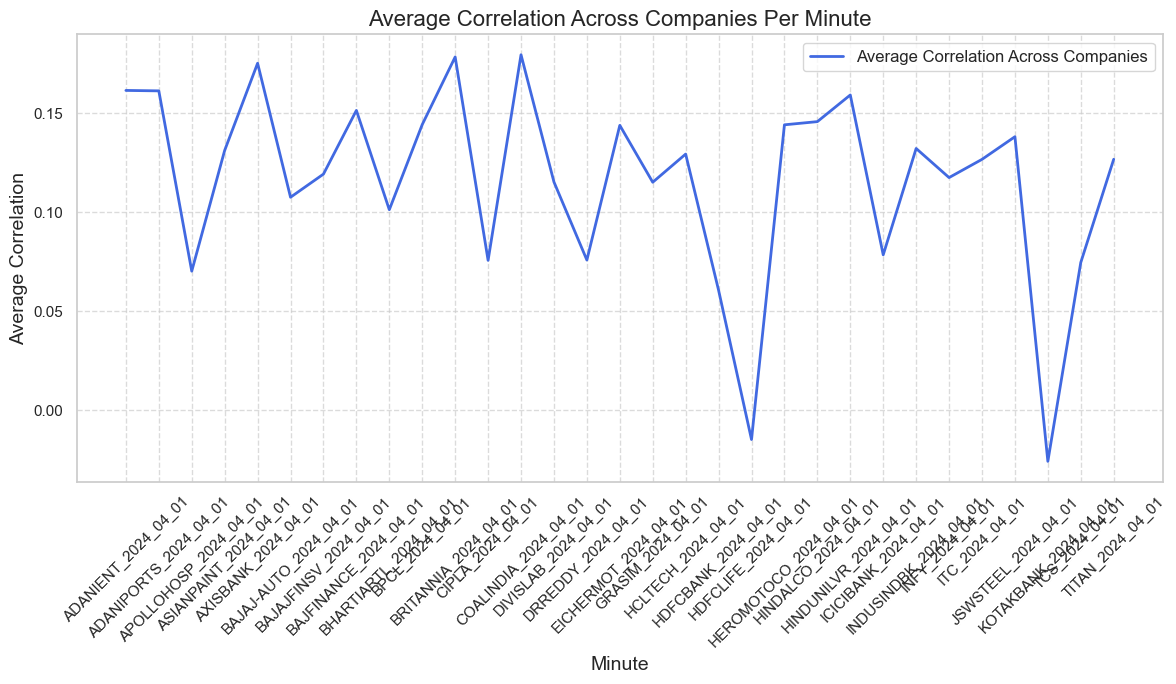

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(correlation_per_minute.index, correlation_per_minute.values, label='Average Correlation Across Companies', color='royalblue', linewidth=2)

# Enhance the appearance of the plot
plt.xlabel('Minute', fontsize=14)
plt.ylabel('Average Correlation', fontsize=14)
plt.title('Average Correlation Across Companies Per Minute', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(visible=True, linestyle='--', alpha=0.7)  # Add a grid with a specific style
plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()

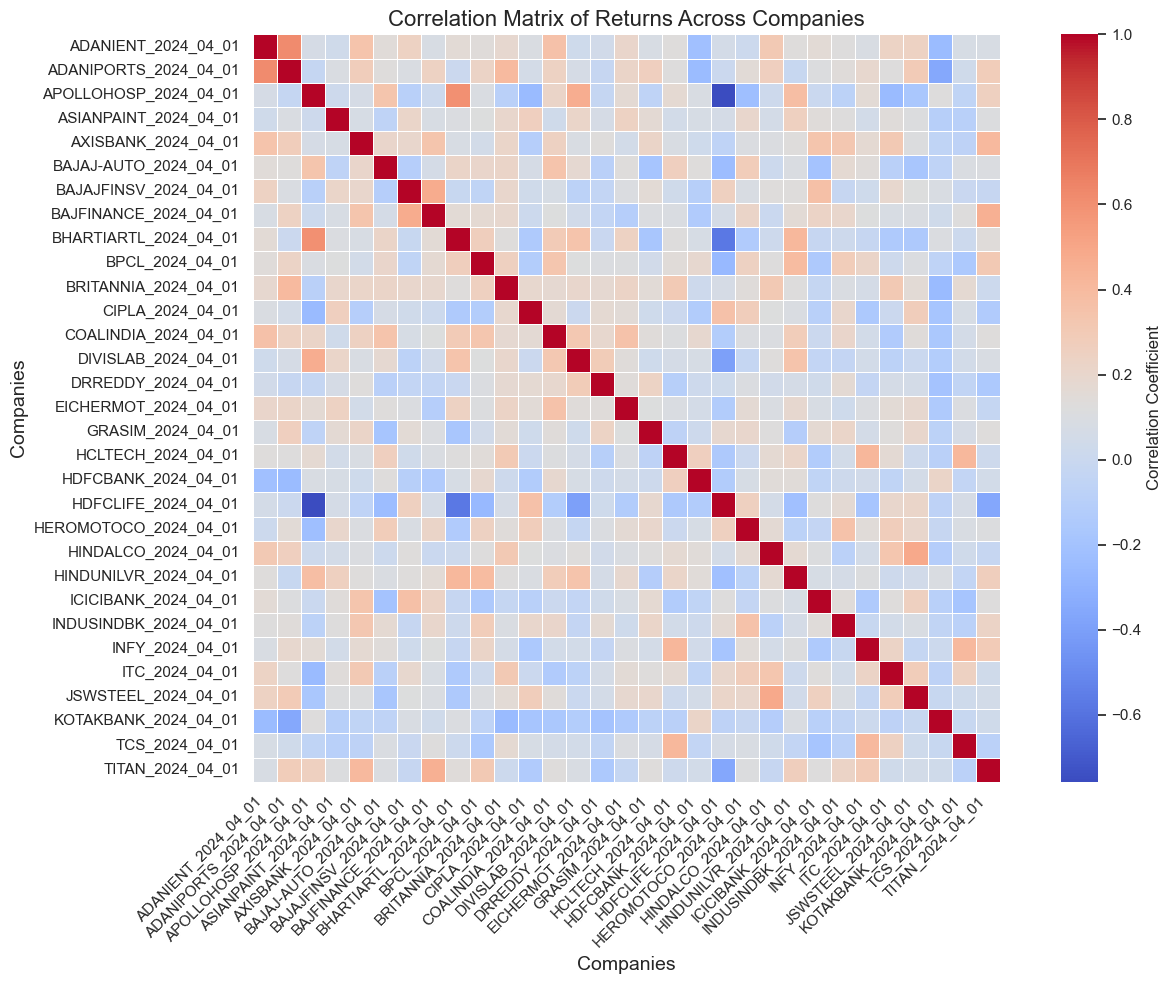

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
sns.set(style="whitegrid")

# Create a pivot table to calculate the returns across companies per minute
pivoted_data = test_data.pivot_table(index='Minute', columns='Company', values='Return')

# Calculate the correlation matrix for the returns
correlation_matrix = pivoted_data.corr()

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f",
            cbar_kws={'label': 'Correlation Coefficient'}, square=True, linewidths=0.5)

# Enhance the appearance of the heatmap
plt.title('Correlation Matrix of Returns Across Companies', fontsize=16)
plt.xlabel('Companies', fontsize=14)
plt.ylabel('Companies', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 

# Show the plot
plt.show()

Average Correlation: 0.1162


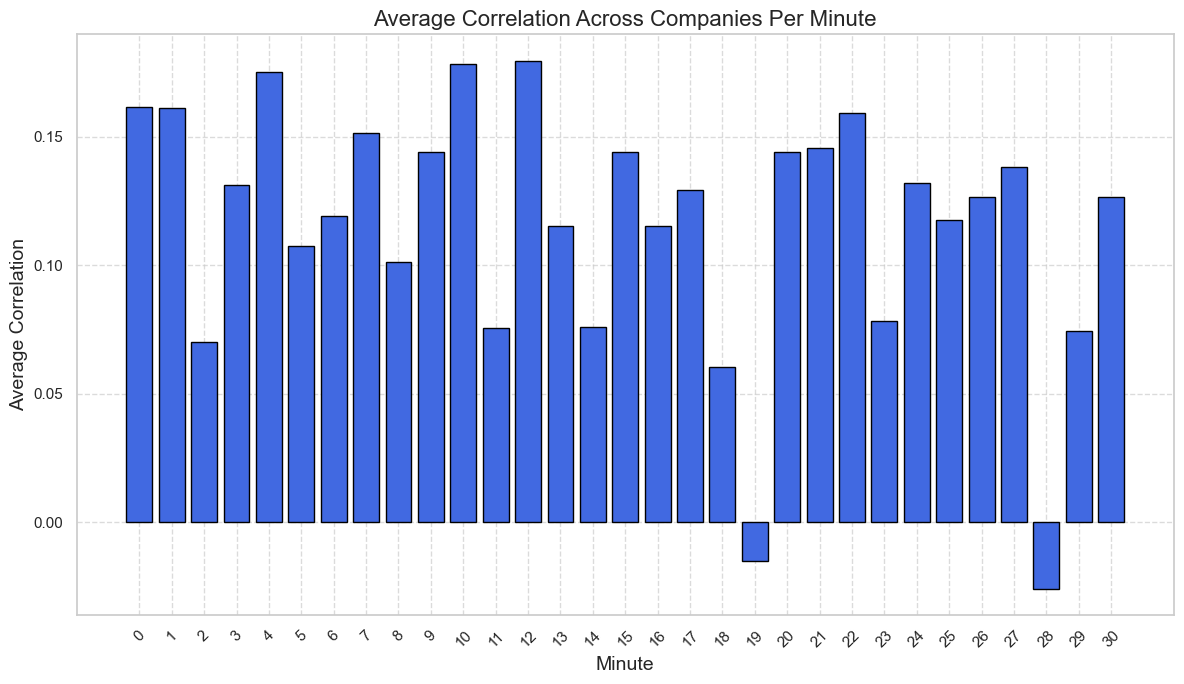

In [21]:
# Calculate the average correlation for each minute
average_correlation = correlation_per_minute.mean()  # No axis argument needed

# Print average correlation
print(f"Average Correlation: {average_correlation:.4f}")

# Optional: Create a bar plot for average correlation
plt.figure(figsize=(12, 7))
plt.bar(range(len(correlation_per_minute)), correlation_per_minute.values, color='royalblue', edgecolor='black')

# Enhance the appearance of the bar plot
plt.xlabel('Minute', fontsize=14)
plt.ylabel('Average Correlation', fontsize=14)
plt.title('Average Correlation Across Companies Per Minute', fontsize=16)
plt.xticks(range(len(correlation_per_minute)), rotation=45)  
plt.grid(visible=True, linestyle='--', alpha=0.7)  

# Show the plot
plt.tight_layout()
plt.show()
